In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
plt.rc('figure', facecolor='w')
plt.rc('font', size=11)

DT_GH = 1
RT = 0.0019872 * 300

In [2]:
def read_pmf(filename):
    return np.loadtxt(filename).T[:2]

string = np.loadtxt('data/YOPH.string').T
full_pmf = read_pmf('data/YOPH_pmf.dat')
full_pmf[1] = full_pmf[1] - np.min(full_pmf[1,:50])
split_pmf = np.array([read_pmf(f'data/YOPH_split_pmf/{i}.dat') for i in range(1, 6)])
react_idx = np.argmin(full_pmf[1])
split_pmf[:,1,:] = split_pmf[:,1,:] - split_pmf[:,1,react_idx][:,None]
err = np.std(split_pmf[:,1,:], axis=0)

/home/kirill/anaconda3/envs/PTP1B/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [3]:
data = np.moveaxis([np.loadtxt(f'data/YOPH_gh/{i+1}.gh') for i in range(60)], 2, 0)

keys = ('mass', 'full', 'solvent', 'protein_intra', 'only_cmap', 'only_torsions')
data_dict = {k: v for k, v in zip(keys, data)}
data_dict['all_torsions'] = data_dict['only_torsions'] + data_dict['only_cmap']

m = np.mean(data_dict['mass'])

In [4]:
def get_autocorr(f, m, rt):
    beta = 1. / rt
    y_raw = np.correlate(f, f, 'same')
    y = y_raw[len(y_raw) // 2:] / np.arange(len(f), len(f) // 2, -1)
    return y * beta / m * 4.184E26


def get_mean_autocorr(f, m, rt):
    return np.mean(np.array([get_autocorr(_, m, rt) for _ in f]), axis=0)


def remove_mean(x):
    return x - np.mean(x, axis=1)[:, None]

xi_dict = {k: get_mean_autocorr(remove_mean(f), m, RT) 
           for k, f in data_dict.items()}

In [5]:
acf_ps_dict = {k: np.abs(np.fft.rfft(v))**2 for k, v in xi_dict.items()}

In [6]:
def plot_a(ax):
    ax.set_xlabel('s (a.m.u.$^{1/2}\cdot\AA$)')
    ax.set_ylabel('PMF (kcal/mol)')
    ax.set_xlim([0, 50])
    ax.set_ylim([-5, 15])
    ax.plot(full_pmf[0], full_pmf[1], c='navy')
    ax.fill_between(full_pmf[0],  full_pmf[1] - err, 
                    full_pmf[1] + err,
                    facecolor='blue',
                    alpha=0.2)

In [7]:
def plot_b(ax1):
    ax2 = ax1.twinx()
    ax1.set_xlabel('s (a.m.u.$^{1/2}\cdot\AA$)')
    ax2.set_ylabel('Distance ($\AA$)')
    ax1.set_xlim(-3, 42)
    ax2.set_ylim(1.5,14.5)
    ax1.set_ylabel('Angle ($\degree$)', labelpad=-5)
    ax1.set_ylim(-240,360)
    x = string[0]

    colors = ('blue', 'red', 'purple', 'green', 'orange')
    labels = ('$\Psi_{357}$', 
              '$\Phi_{358}$',
              '$d_1$', 
              '$d_2$',
              '$d_3$',)
    for y, c in zip(string[4:6], colors[3:]):
        ax1.plot(x, y, c=c)    
    for y, c in zip(string[1:4], colors[:3]):
        ax2.plot(x, y, c=c, linestyle='dashed')    

    ax1.legend(ax1.lines + ax2.lines, labels, loc='lower center', 
               ncol=5, columnspacing=0.5, handletextpad=0.4, )

In [8]:
names_dict = {'full': 'full',
              'solvent': 'solvent',
              'protein_intra': 'intramolecular (protein)',
              'all_torsions': 'torsions (all)',
              'only_cmap': '$\Psi-\Phi$',
              'only_torsions': 'rest of torsions'}

colors_dict = {'full': 'grey',
              'solvent': 'blue',
              'protein_intra': 'red',
              'all_torsions': 'purple',
              'only_cmap': 'green',
              'only_torsions': 'orange'}

def plot_c(ax):
    x = np.arange(len(xi_dict['full'])) * DT_GH

    for key in ('full', 'solvent', 'protein_intra'):
        ax.plot(x, xi_dict[key] *1E-30, lw=2, label=names_dict[key], c=colors_dict[key])

    ax.set_xlim([0, 500])
    ax.set_xlabel('Time (fs)')
    ax.set_ylabel('$\\xi$ (fs$^{-2}$)')
    ax.legend()

In [9]:
def plot_d(ax):
    x = np.arange(len(acf_ps_dict['full'])) * 1.0E11 / 2.9979E10 #cm^-1
    for key in ('full', 'all_torsions', 'only_cmap', 'only_torsions'):
        ax.plot(x[1:], acf_ps_dict[key][1:] * 1.E-60, lw=2, 
                label=names_dict[key], c=colors_dict[key])
    ax.set_xlim([0, 1000])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('Freq ($cm^{-1}$)')
    ax.set_ylabel('PS($\\xi$) (fs$^{-4}$)')
    ax.legend()

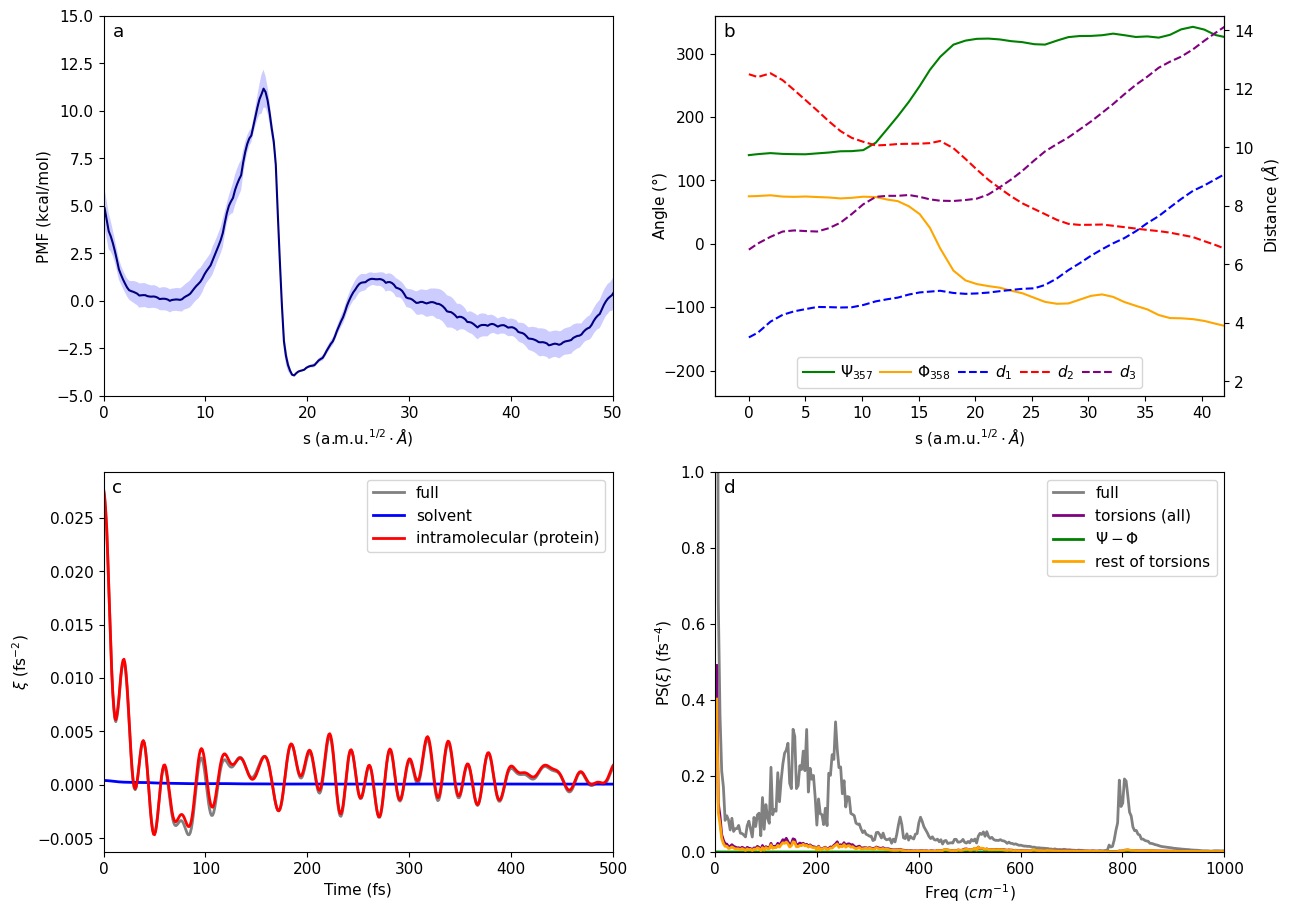

In [10]:
fig, axs = plt.subplot_mosaic([['a', 'b'], ['c', 'd']], figsize=(12,9))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plot_a(axs['a'])
plot_b(axs['b'])
plot_c(axs['c'])
plot_d(axs['d'])

for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-0.01, 1.0, label, transform=ax.transAxes + trans, 
            verticalalignment='top', fontsize='large')

plt.savefig('Fig5.png', dpi=300, bbox_inches='tight')
plt.show()